# Data Compression using the SVD

The singular value decomposition (SVD) can be used for compressing data in a matrix. In this example, we will take a digital photo and do a lossy compression based on the SVD. Ideally, we should get a new image which is not visibly different from the original but requires less stored data to reconstruct. 

In [1]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt

## Digital photo as a numpy array

We start by loading a digital photo and storing it as an array $X$. 

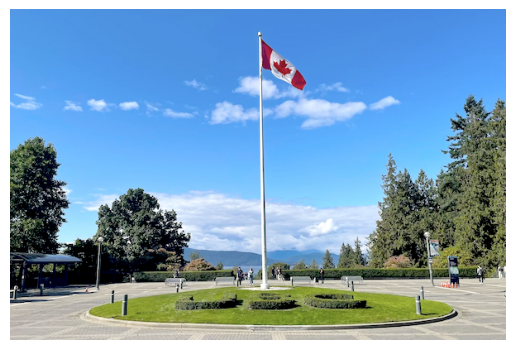

In [2]:
X = plt.imread('photo.jpg').astype(np.uint8)
plt.imshow(X)
plt.axis('off')
plt.show()

The image used for this demonstration is 400 pixels tall and 600 pixels wide, so here $X$ is a $400\times 600$ matrix where each entry is a 3D array representing the RGB channel values for one pixel in the image. 

In [3]:
print(X.shape)

(400, 600, 3)


We can select one of the pixels and check its colour. The three values (between 0 and 255) represent the amount of red, green and blue in the colour of that pixel. 

In [4]:
print(X[12,45])

[ 79 151 233]


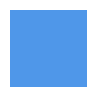

In [5]:
# Plot a small square of this colour   
fig=plt.figure(figsize=(1, 1))
plt.axis('off')
plt.imshow(np.array([[X[12,45]]]))
plt.show()

### Using the SVD to compress data

Let $A=P\Sigma Q^T$ be the SVD of an $m \times n$ matrix $A$. We can also write this as the sum
$$A = \sum_{i=1}^r \sigma_i p_i q_i^T = \sigma_1 p_1 q_1^T + \dots + \sigma_r p_r q_r^T,$$
where $r$ is the rank of $A$. The singular values $\sigma_1, \sigma_2, \dotsc, \sigma_r$ are in decreasing order, so the first term with $\sigma_1$ will be the most significant, while terms with smaller singular values will not contribute as much to the matrix $A$. This allows us to compress the data in an efficient way, since we can choose to leave out the *least significant* terms in the sum above. 

We get a rank $k$ approximation of $A$ by replacing all singular values after $\sigma_k$ with zero, 
$$A_k = \sum_{i=1}^k \sigma_i p_i q_i^T = \sigma_1 p_1 q_1^T + \dots + \sigma_k p_k q_k^T, \quad (1\leq k \leq r).$$

For the matrix $A_k$ we only need to store the first $k$ columns of matrices $P$ and $Q$, as well as the $k$ singular values $\sigma_1, \dotsc, \sigma_k$. The total number of stored values is therefore equal to $m\cdot k + k + k\cdot n = k(m+n+1)$. This can be compared to the $mn$ values needed in the original matrix $A$. The *compression ratio* is the ratio between the uncompressed and compressed amounts of data, in this case
$$\text{Compression Ratio} = \frac{mn}{k(m+n+1)}$$. 

### SVD compression of the digital photo

We will now perform the compression described above for our digital image matrix $X$. Since we have three different colour channels, we actually find the SVD and do the compression for each channel separately. 
(This might take some time if the photo is very large — for me the following code took several minutes using the Syzygy service but was much faster when run in a local IDE.)

In [6]:
# Separate X into one matrix for each colour channel
R = X[:, :, 0]
G = X[:, :, 1]
B = X[:, :, 2]

# Find the SVD of the three matrices
# We can set 'full_matrices' to false since we are going to truncate anyway
PR,SR,QRT = la.svd(R, full_matrices=False)
PG,SG,QGT = la.svd(G, full_matrices=False)
PB,SB,QBT = la.svd(B, full_matrices=False)

The following function will display the amount of compression obtained for a given value $k$ in the truncated SVD, and reconstruct the corresponding compressed image. 

In [7]:
def compressImage(k):
    # k is the number of singular values to keep

    # Construct the truncated versions of the colour channel matrices
    newR = PR[:,:k] @ np.diag(SR[:k]) @ QRT[:k,:]
    newG = PG[:,:k] @ np.diag(SG[:k]) @ QGT[:k,:]
    newB = PB[:,:k] @ np.diag(SB[:k]) @ QBT[:k,:]

    # Make sure that the new matrices are of the right format
    newR = np.clip(newR, 0, 255).astype(np.uint8)
    newG = np.clip(newG, 0, 255).astype(np.uint8)
    newB = np.clip(newB, 0, 255).astype(np.uint8)

    # Combine the three new matrices into one
    newX = np.dstack((newR,newG,newB))

    # Plot the new matrix as an image
    plt.imshow(newX)
    plt.axis('off')
    plt.show

    # Display the compression ratio 
    # i.e. how much data needs to be stored compared to the original matrix
    xm = X.shape[0]
    xn = X.shape[1]
    cratio = (xm * xn) / (k * (xm + xn + 1))
    csave = 100 / cratio
    print("Amount of data compared to original: ","{:.2f}".format(csave),"%", 
        " (Compression ratio: ","{:.1f}".format(cratio),")")

We can now test different values of $k$ and observe how the compressed image changes. 

Amount of data compared to original:  0.42 %  (Compression ratio:  239.8 )


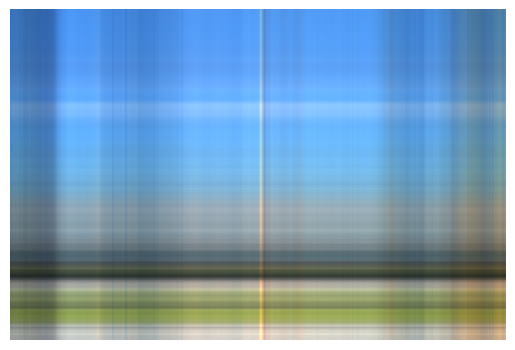

In [8]:
compressImage(1)

Amount of data compared to original:  3.34 %  (Compression ratio:  30.0 )


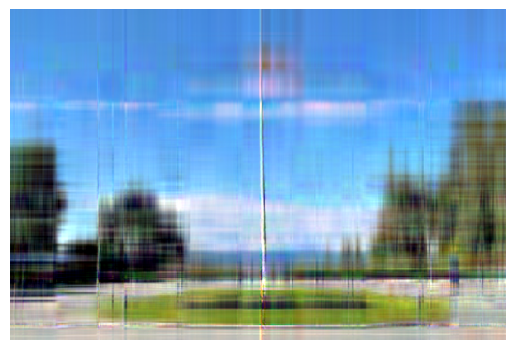

In [9]:
compressImage(8)

Amount of data compared to original:  10.43 %  (Compression ratio:  9.6 )


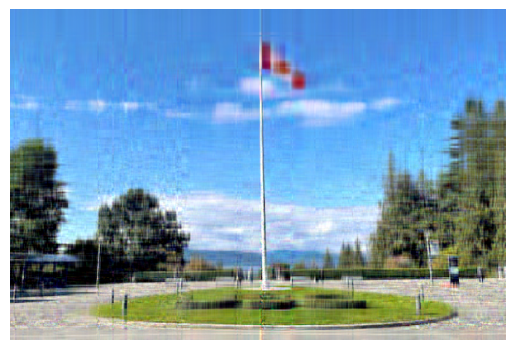

In [10]:
compressImage(25)

Amount of data compared to original:  41.71 %  (Compression ratio:  2.4 )


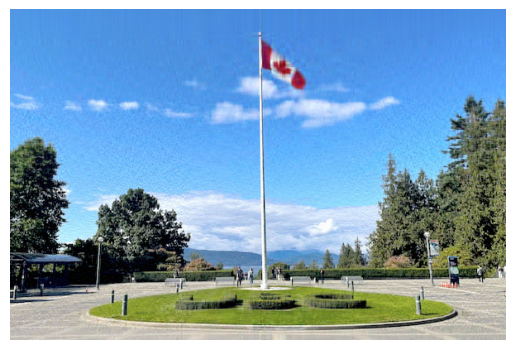

In [11]:
compressImage(100)

Amount of data compared to original:  83.42 %  (Compression ratio:  1.2 )


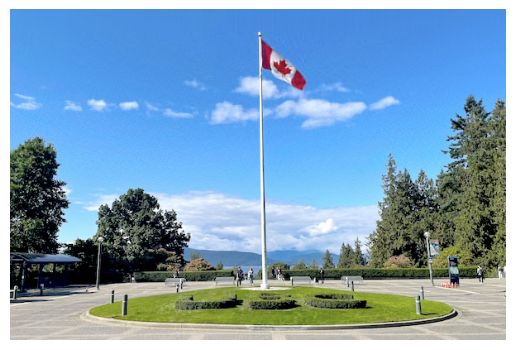

In [12]:
compressImage(200)

Amount of data compared to original:  166.83 %  (Compression ratio:  0.6 )


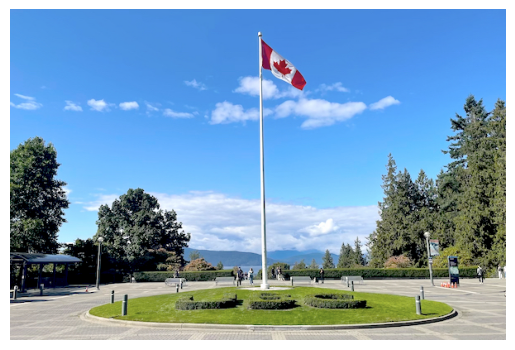

In [13]:
compressImage(400)

### Comments

When selecting the value $k$, there is a trade-off between better image quality and more compression. If we keep *every* singular value, we actually store more data than before (which makes sense, since the SVD contains more information than just the matrix $A$). Based on the images above, we can see that there is barely any difference from the original image if we keep half of the singular values ($k=200$), whereas we then only need to store around 83% of the amount of data. Going down to $k=100$, we do notice a difference in quality. If we keep only a handful of the singular values, the approximation will certainly not be very good, but it will also require only a small fraction of the amount of data. It is curious to note that in this particular example, the main feature of the photo — the flagpole — is still somewhat recognizable even if we keep *only* the largest singular value ($k=1$), although obviously the image is otherwise not a good approximation at that point. 

The SVD can be used for compressing matrix data in general, but when it comes to compressing digital images in particular, it is much more common to use a discrete cosine transform (DCT) instead. This is the method implemented in, for instance, the JPEG compression. The DCT is related to the Discrete Fourier Transform, which you will learn about during the final weeks of the course. Nevertheless, the example above serves as a nice visual illustration of the truncated SVD expansion and how it can be applied for data compression. 